### Generate Map Tiles as Training Images

- this needs gdal installation and https://github.com/tehamalab/gdal2tiles (`pip install gdal2tiles`)
- gdal installation is `sudo apt-get install libgdal-dev` and `pip install GDAL` on linux. Not sure about windows, installing GDAL there is kind of difficult.

- to generate the training images run the cell below. At the top change `SHAPE_ORIGINAL` and `SHAPE_GENERALIZED` to the local file locations of our dataset from here (https://git.tu-berlin.de/project-geoinformatics-2023/data-preparation/-/tree/main/data)
- if successfully run, it produces two subfolders in the current directory called `tiles_original` and `tiles_simplified`, where the map images are located. The corresponding pairs can be identified by the file name.

- parameters like `zoom` and `image_size` can be adapted if required.

In [ ]:
import gdal2tiles
import os
import shutil
import itertools
from pathlib import Path

from PIL import Image
import geopandas as gpd
from osgeo import gdal, ogr, osr

SHAPE_ORIGINAL = 'data/buildings.shp'
SHAPE_GENERALIZED ='data/simplified.shp'


def generate_training_tiles(shapefile_path, out_path, zoom='17', image_size=256):
    # Load the shapefile
    gdf_original = gpd.read_file(shapefile_path)
    gdf_original = gdf_original.to_crs(3857)
    gdf_original.to_file('shape_3857.shp')
    
    # Define pixel_size
    pixel_size = 0.2 # this is 1px in real world meters (e.g. 0.2=20cm resolution)
    
    # Filename of the raster Tiff that will be created
    raster_fn = 'rasterized_buildings.tif'
    
    # Open the data source and read in the extent
    source_ds = ogr.Open('shape_3857.shp')
    source_layer = source_ds.GetLayer()
    x_min, x_max, y_min, y_max = source_layer.GetExtent()
    
    # Create the destination data source
    x_res = int((x_max - x_min) / pixel_size)
    y_res = int((y_max - y_min) / pixel_size)
    print(x_res, y_res)
    target_ds = gdal.GetDriverByName('GTiff').Create(raster_fn, x_res, y_res, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(3857)
    target_ds.SetProjection(srs.ExportToWkt())

    target_ds.GetRasterBand(1).Fill(0) # background black
    
    # Rasterize
    gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[255]) # burn polygons as white

    # release dataset lock
    target_ds = None
    source_ds = None
    
    # write tiles
    gdal2tiles.generate_tiles(raster_fn, out_path, nb_processes=4, zoom=zoom, s_srs='ESPG:3857', tilesize=image_size)

    # cleanup directory structure 
    # and filter out images that are not square and the ones containing no buildings
    all_files = []
    for root, _dirs, files in itertools.islice(os.walk(out_path), 1, None):
        for filename in files:
            path = Path(os.path.join(root, filename))
            new_filename = f"{path.parent.name}_{path.name}"
            new_filepath = path.parent / new_filename
            path.rename(new_filepath)
            if not is_valid_tile(new_filepath):
                continue
            all_files.append(new_filepath)
    print(f'created {len(all_files)} images)')
    for filename in all_files:
        # remove alpha band
        image = Image.open(filename).convert("L")
        image.save(filename)

        # move to output
        shutil.move(filename, out_path)

    # delete intermediary files
    os.remove(raster_fn)
    os.remove('shape_3857.shp')


def is_valid_tile(image_path):
    """ checks if the given image contains any buildings
        and whether it has same dimensions """
    image = Image.open(image_path).convert('L')
    width, height = image.size
    if not width == height:
        return False

    if not image.getbbox(): # completely black => no buildings
        return False

    return True
    

generate_training_tiles(SHAPE_ORIGINAL, 'tiles_original/')
generate_training_tiles(SHAPE_GENERALIZED, 'tiles_simplified/')


51758 51139
Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
created 723 images)
51762 51141
Generating Base Tiles:
0...10...20..

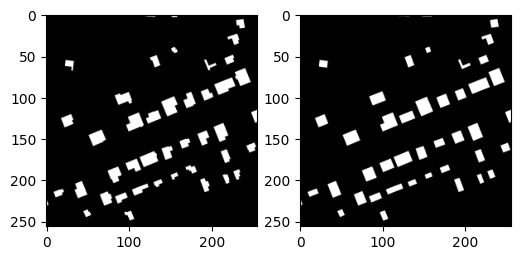

In [42]:
# visualize sample image
import matplotlib.pyplot as plt
from PIL import Image

imgs = [Image.open('tiles_original/70467_88074.png'), Image.open('tiles_simplified/70467_88074.png')]

_, axs = plt.subplots(1, 2, figsize=(6, 6))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img, cmap='gray')
plt.show()

### Generate Single Buildings as Training Images


In [10]:
import os
import math

import fiona
import geopandas as gpd
from shapely.geometry import shape, box

import rasterio
import rasterio.features
from rasterio.features import geometry_mask, rasterize
from rasterio.transform import Affine, from_origin
from PIL import Image, ImageDraw

from pyproj import Transformer

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

2023-07-01 19:26:00.024825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 19:26:00.910224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
class BuildingsDataset(tf.keras.utils.Sequence):
    def __init__(self, shape_path_original, shape_path_generalized, img_size=(128, 128), batch_size=16):
        self.shape_path_original = shape_path_original
        self.shape_path_generalized = shape_path_generalized

        self.batch_size = batch_size
        self.img_size = img_size
    
        self.gdf_original = gpd.read_file(self.shape_path_original)
        self.gdf_generalized = gpd.read_file(self.shape_path_generalized)
    
    def __len__(self):
        return math.ceil(len(self.gdf_original) / self.batch_size)

    def image_from_geometry(self, geom):
        bounds = geom.bounds # (minx, miny, maxx, maxy)

        # Calculate the current width and height of the building
        width = bounds[2] - bounds[0]
        height = bounds[3] - bounds[1]

        # Calculate the desired width and height of the building (e.g., 50% of the original size)
        desired_width = width * 1.5
        desired_height = height * 1.5

        # Calculate the adjustment needed to center the building in the image
        dx = (width - desired_width) / 2
        dy = (height - desired_height) / 2

        # Adjust the bounds of the building's footprint
        new_bounds = (
            bounds[0] + dx,
            bounds[1] + dy,
            bounds[2] - dx,
            bounds[3] - dy
        )

        transform = from_origin(new_bounds[0], new_bounds[3], (new_bounds[2] - new_bounds[0]) / self.img_size[0], (new_bounds[3] - new_bounds[1]) / self.img_size[1])

        # Create a new binary image of size 128x128 pixels
        shapes = [(geom, 255)]
        img_array = rasterize(shapes, out_shape=self.img_size, transform=transform)

        return img_array
    
    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.gdf_original))
        batch_x = self.gdf_original[low:high]['geometry']
        batch_y = self.gdf_generalized[low:high]['geometry']

        return (
            [self.image_from_geometry(geom_orig) for geom_orig in batch_x], 
            [self.image_from_geometry(geom_gen) for geom_gen in batch_y]
        )



In [ ]:
class MapDataset(tf.keras.utils.Sequence):
    def __init__(self, shape_path_original, shape_path_generalized, img_size=(128, 128), batch_size=16):
        self.shape_path_original = shape_path_original
        self.shape_path_generalized = shape_path_generalized

        self.batch_size = batch_size
        self.img_size = img_size
    
        self.gdf_original = gpd.read_file(self.shape_path_original)
        self.gdf_generalized = gpd.read_file(self.shape_path_generalized)
    
    def __len__(self):
        return math.ceil(len(self.gdf_original) / self.batch_size)
    
    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.gdf_original))
        batch_x = self.gdf_original[low:high]['geometry']
        batch_y = self.gdf_generalized[low:high]['geometry']

        return (
            [self.image_from_geometry(geom_orig) for geom_orig in batch_x], 
            [self.image_from_geometry(geom_gen) for geom_gen in batch_y]
        )

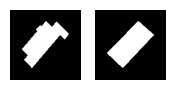

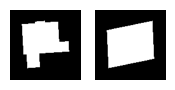

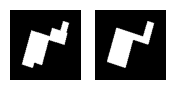

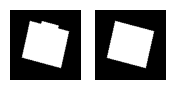

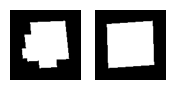

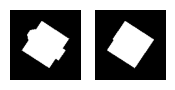

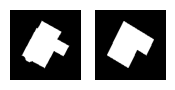

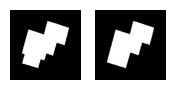

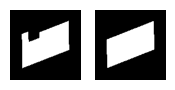

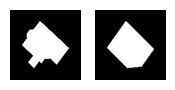

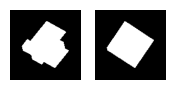

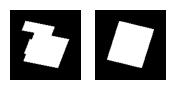

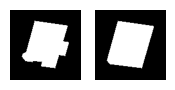

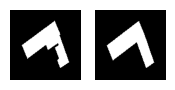

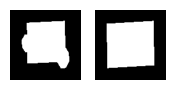

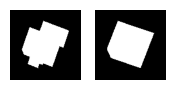

In [56]:
import random

dataset = BuildingsDataset('data/buildings.shp', 'data/simplified.shp')

# display a first sample from the dataset
data = random.sample(list(dataset), 1)[0]

for i in range(dataset.batch_size):
    fig, ax = plt.subplots(1, 2, figsize=(2, 2))  
    
    ax[0].imshow(data[0][i], cmap='gray')
    ax[0].axis('off')
    
    ax[1].imshow(data[1][i], cmap='gray')
    ax[1].axis('off')